In [1]:
# Packages
library(ggplot2)  # visualization
library(dplyr)    # data manipulation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Read the dataset and load it to a data frame
file_path <- "/content/CreditCardFraud_Dataset-4.csv"
df <- read.csv(file_path)
# Data transformations
df$MerchantID <- as.factor(df$MerchantID)         # Ensures proper grouping in plots/summaries
df$TransactionType <- as.factor(df$TransactionType)  # So ggplot doesn't treat it as text
df$Class <- factor(df$Class, levels = c("Normal", "Fraudulent"))  # So "Fraudulent" is the positive class

In [3]:
# Time represents the elapsed time in seconds from the first transaction in the dataset, not the transaction duration.

In [4]:
range(df$Time)

[1]     15 172793

In [5]:
# Total Number of Days Covered in the Dataset
max(df$Time) / 86400
# Total Number of Hours Covered in the Dataset
max(df$Time) / 3600

[1] 1.999919

[1] 47.99806

In [6]:
# The dataset spans approximately 48 hours, or two full days of transaction activity.
# As a result, features such as Day lack variability and are unlikely to be informative in a logistic regression model.
# However, Hour (0–23) provides repeated daily cycles and can capture behavioral patterns across time of day,
# making it a suitable temporal feature for classification.

In [7]:
# Convert Time to Hour
df$Hour <- floor(df$Time / 3600) %% 24
# Convert Time to Day
df$Day <- floor(df$Time / 86400)

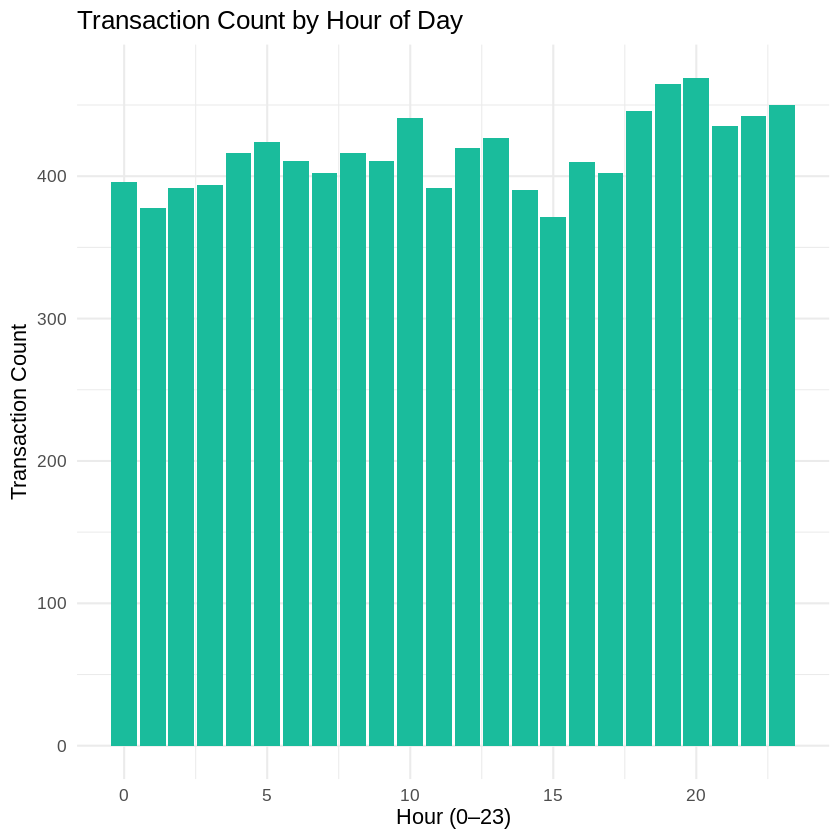

In [8]:
# Transaction Count by Hour of Day
ggplot(data = as.data.frame(table(df$Hour)), aes(x = as.numeric(as.character(Var1)), y = Freq)) +
  geom_col(fill = "#1ABC9C") +
  labs(
    title = "Transaction Count by Hour of Day",
    x = "Hour (0–23)",
    y = "Transaction Count"
  ) +
  theme_minimal(base_size = 13)

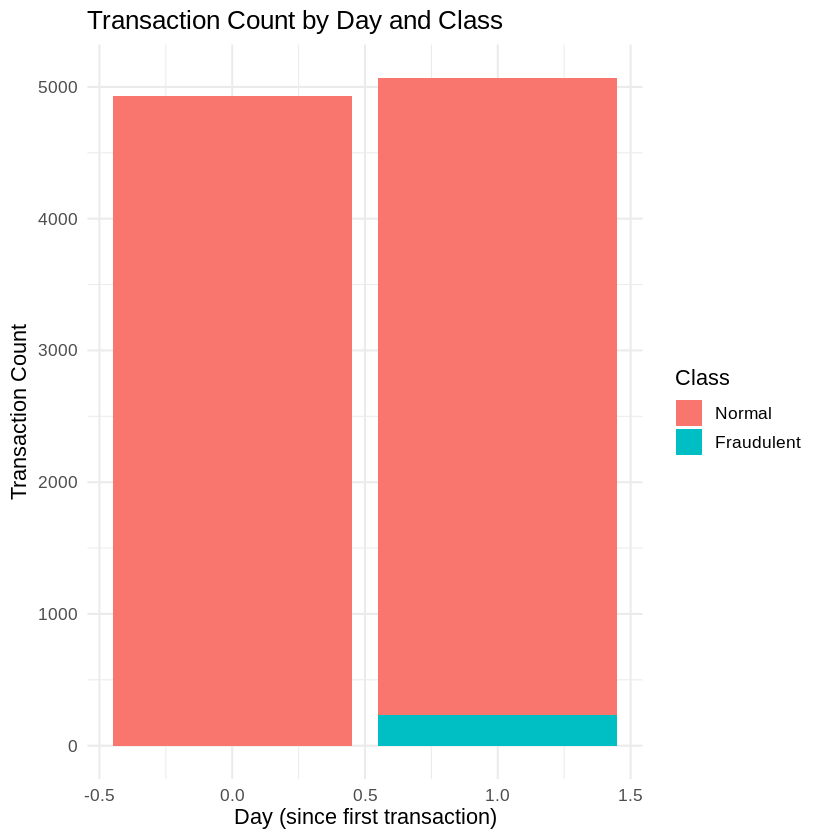

In [9]:
# Create Day column if not already
df$Day <- floor(df$Time / 86400)

# Count transactions per Day and Class
day_class_counts <- df %>%
  count(Day, Class)

# Plot stacked bars
ggplot(day_class_counts, aes(x = Day, y = n, fill = Class)) +
  geom_col() +
  labs(
    title = "Transaction Count by Day and Class",
    x = "Day (since first transaction)",
    y = "Transaction Count",
    fill = "Class"
  ) +
  theme_minimal(base_size = 13)


In [10]:
# Count Class per Day
fraud_normal_by_day <- df %>%
  count(Day, Class) %>%
  tidyr::pivot_wider(
    names_from = Class,
    values_from = n,
    values_fill = 0
  )
print(fraud_normal_by_day)

# A tibble: 2 × 3
    Day Normal Fraudulent
  <dbl>  <int>      <int>
1     0   4932          0
2     1   4835        233


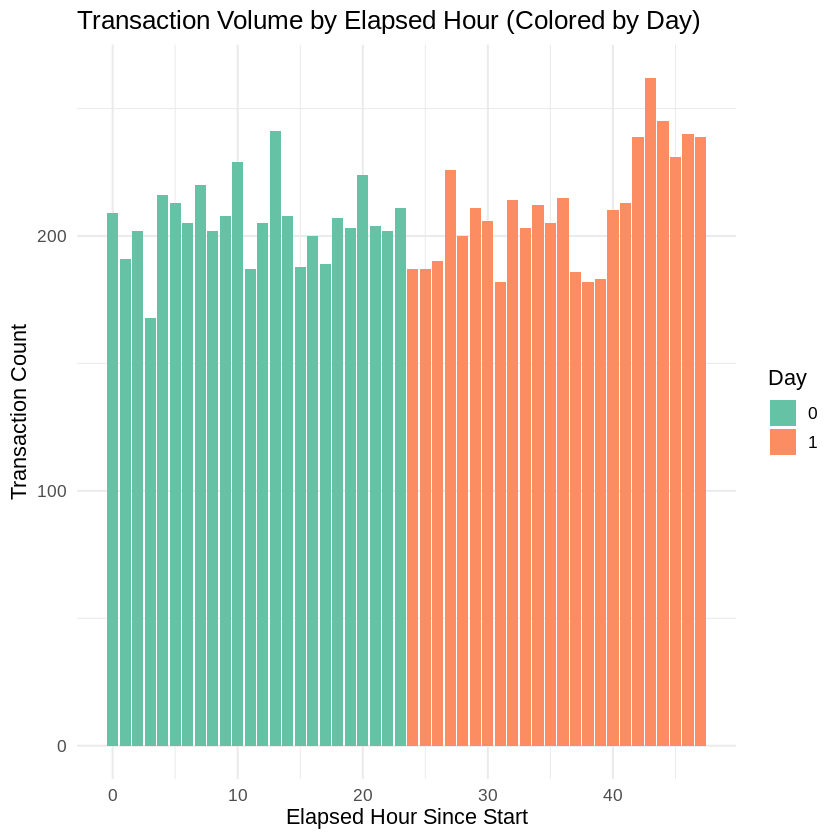

In [11]:
# Step 1: Create the elapsed hour and day columns
df$ElapsedHour <- floor(df$Time / 3600)
df$Day <- floor(df$Time / 86400)

# Step 2: Count transactions by ElapsedHour and Day
hour_day_counts <- df %>%
  count(ElapsedHour, Day)

# Step 3: Plot
ggplot(hour_day_counts, aes(x = ElapsedHour, y = n, fill = factor(Day))) +
  geom_col() +
  scale_fill_brewer(palette = "Set2", name = "Day") +
  labs(
    title = "Transaction Volume by Elapsed Hour (Colored by Day)",
    x = "Elapsed Hour Since Start",
    y = "Transaction Count"
  ) +
  theme_minimal(base_size = 13)

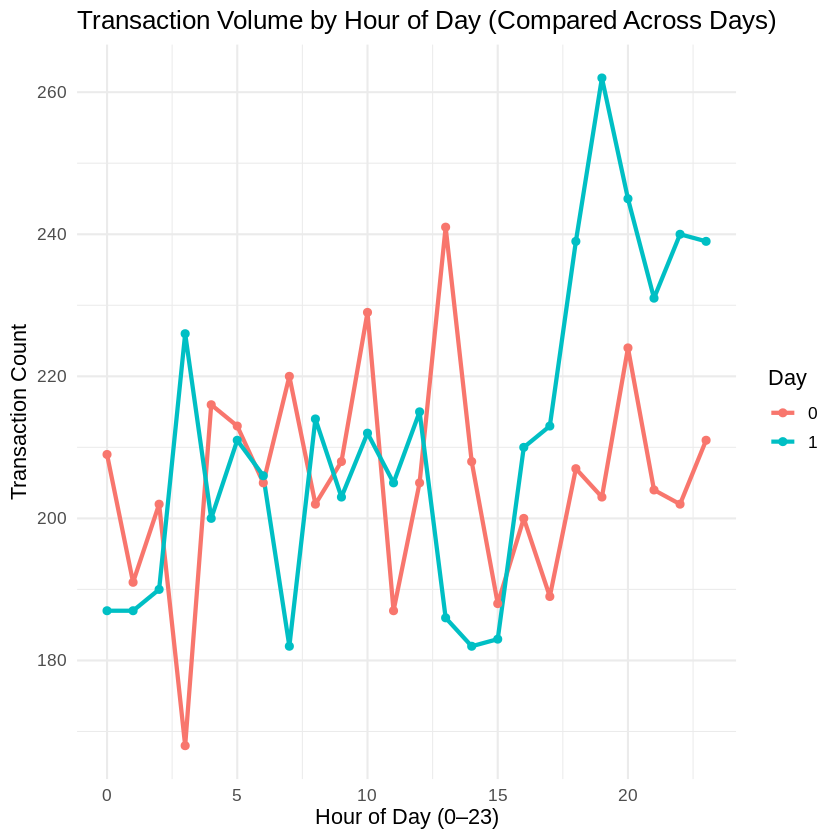

In [12]:
# Step 1: Create Hour and Day features
df$Hour <- floor(df$Time / 3600) %% 24
df$Day <- floor(df$Time / 86400)
# Step 2: Count transactions per Hour per Day
hour_day_counts <- df %>%
  count(Day, Hour)
# Step 3: Plot lines for each day
ggplot(hour_day_counts, aes(x = Hour, y = n, color = factor(Day), group = Day)) +
  geom_line(linewidth = 1.2) +
  geom_point() +
  labs(
    title = "Transaction Volume by Hour of Day (Compared Across Days)",
    x = "Hour of Day (0–23)",
    y = "Transaction Count",
    color = "Day"
  ) +
  theme_minimal(base_size = 13)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


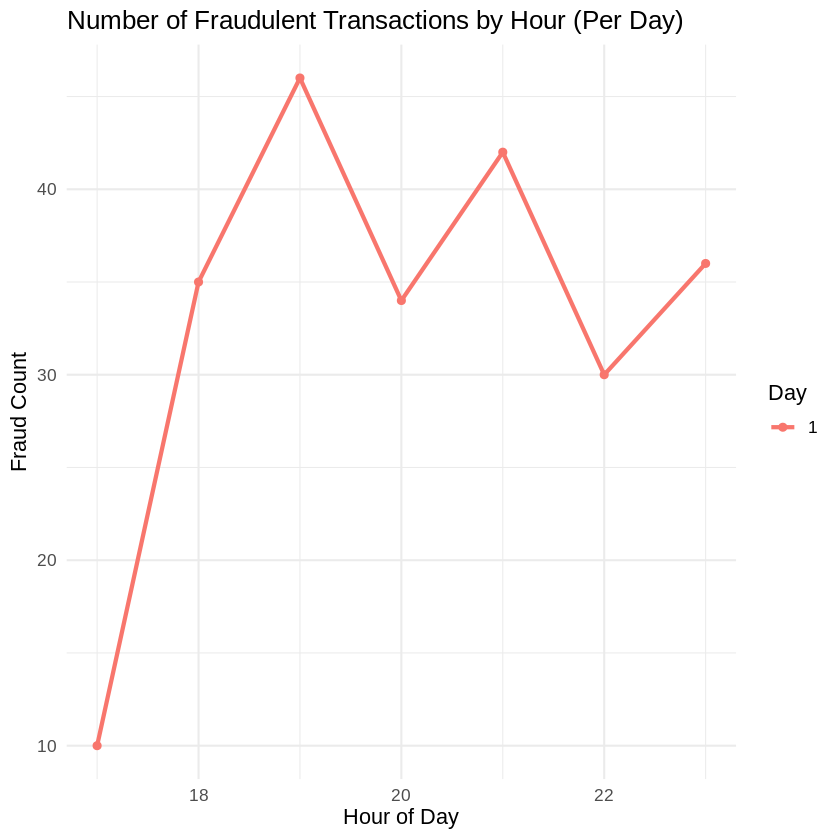

In [13]:
# Prep time features
df$Hour <- floor(df$Time / 3600) %% 24
df$Day <- floor(df$Time / 86400)
# Filter only fraud cases
fraud_counts <- df %>%
  filter(Class == "Fraudulent") %>%
  count(Day, Hour)
# Plot fraud count
ggplot(fraud_counts, aes(x = Hour, y = n, color = factor(Day), group = Day)) +
  geom_line(size = 1.2) +
  geom_point() +
  labs(
    title = "Number of Fraudulent Transactions by Hour (Per Day)",
    x = "Hour of Day",
    y = "Fraud Count",
    color = "Day"
  ) +
  theme_minimal(base_size = 13)

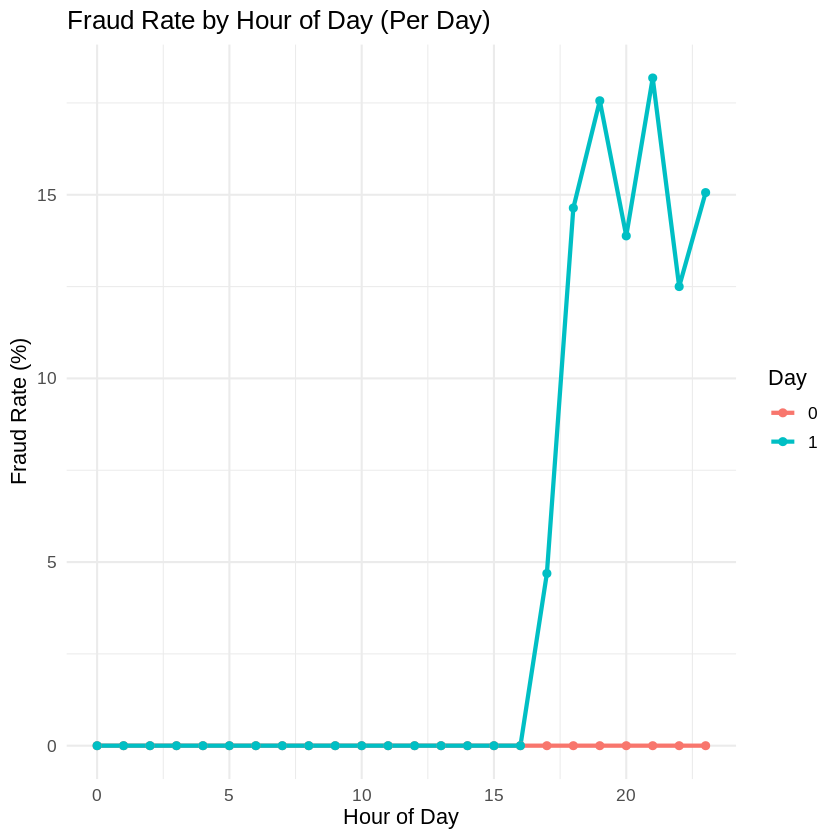

In [14]:
# Total transactions per hour-day
total_counts <- df %>%
  count(Day, Hour)

# Fraud transactions per hour-day
fraud_counts <- df %>%
  filter(Class == "Fraudulent") %>%
  count(Day, Hour)

# Join and calculate fraud rate
fraud_rate <- left_join(total_counts, fraud_counts, by = c("Day", "Hour"))
fraud_rate <- fraud_rate %>%
  mutate(
    FraudCount = ifelse(is.na(n.y), 0, n.y),
    FraudRate = round(100 * FraudCount / n.x, 2)
  )

# Plot fraud rate
ggplot(fraud_rate, aes(x = Hour, y = FraudRate, color = factor(Day), group = Day)) +
  geom_line(size = 1.2) +
  geom_point() +
  labs(
    title = "Fraud Rate by Hour of Day (Per Day)",
    x = "Hour of Day",
    y = "Fraud Rate (%)",
    color = "Day"
  ) +
  theme_minimal(base_size = 13)


In [15]:
summary(df$Hour)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.00   12.00   11.76   18.00   23.00 

In [16]:
var(df$Hour)

[1] 48.27924

In [17]:
sd(df$Hour)

[1] 6.948326

In [18]:
range(df$Hour)

[1]  0 23

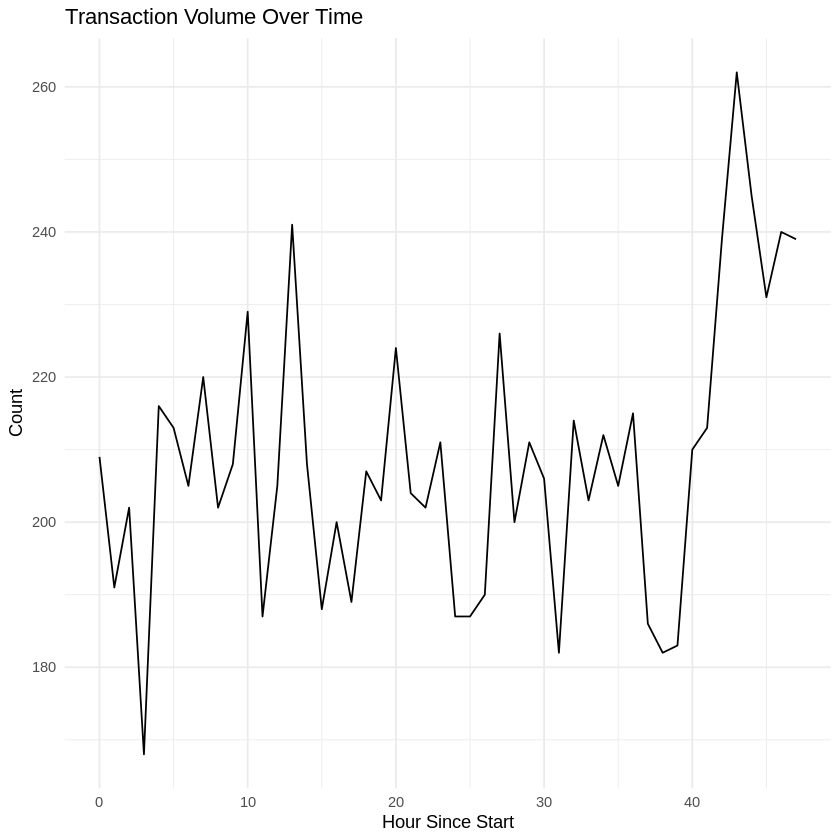

In [19]:
# Transaction Volume Over Time
df %>%
  mutate(Hour = floor(Time / 3600)) %>%
  count(Hour) %>%
  ggplot(aes(x = Hour, y = n)) +
  geom_line() +
  labs(title = "Transaction Volume Over Time", x = "Hour Since Start", y = "Count") +
  theme_minimal()


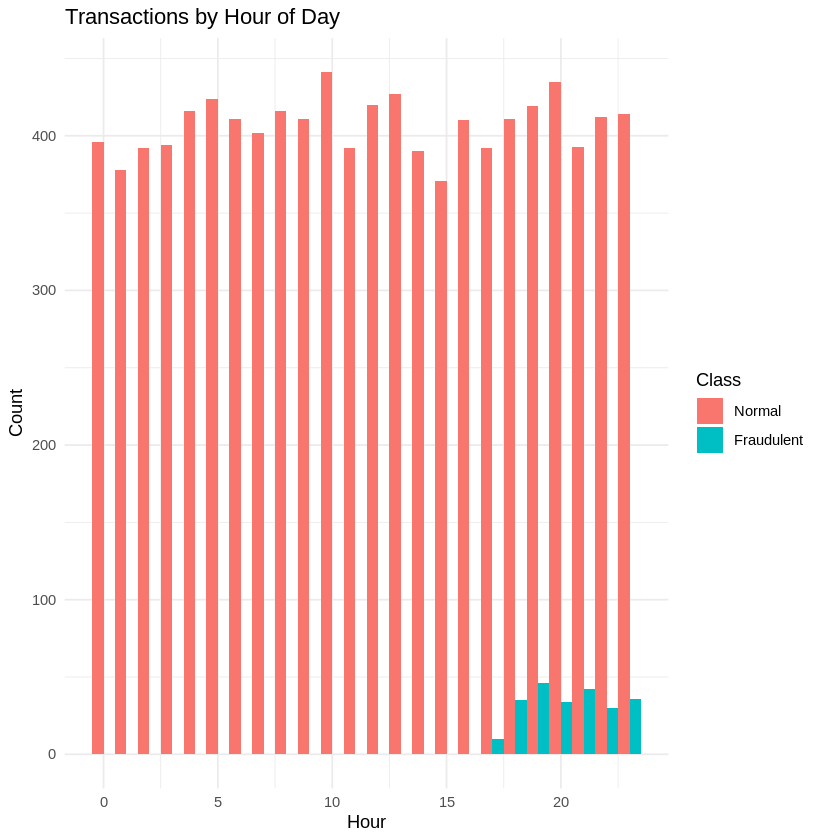

In [20]:
ggplot(df, aes(x = Hour, fill = Class)) +
  geom_histogram(binwidth = 1, position = "dodge") +
  labs(title = "Transactions by Hour of Day", x = "Hour", y = "Count") +
  theme_minimal()